In [130]:
class Value:
    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.label = label
        self.prev = children
        self.operation = operation
        self.grad = 0.0
        self.backward = lambda : None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out.backward = _backward
        return out

    def __sub__(self, other):
        out = Value(self.data - other.data, (self, other), '-')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out.backward = _backward
        return out

    def __truediv__(self, other):
        out = Value(self.data / other.data, (self, other), '/')
        return out
    
    def top_backward(self):
        self.grad = 1.0

        def backward_recursion(parent_node):
            parent_node.backward()
            for node in parent_node.prev:
                backward_recursion(node)
        
        backward_recursion(self)


In [131]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
d = Value (10.0, label='d')
f = Value (-2.0, label='f')

c = a * b; c.label='c'
e = c + d; e.label='e'
L = e * f; L.label='L'

In [132]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

In [133]:
L.top_backward()

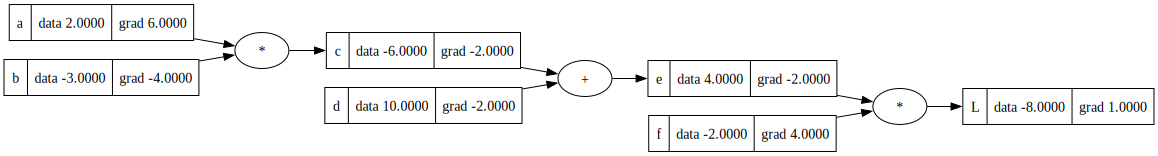

In [134]:
draw_dot(L)